<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/ch7/ch7_nb3_render_images_from_3d_models.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0; border: none;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 7: Training on Complex and Scarce Datasets</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 3:</small><br/>Rendering Images from 3D Models<br/></h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    For many use-cases, collecting large amount of data to train recognition can be costly or impossible. It is, therefore, common in computer vision to generate datasets of <strong>synthetic images</strong> rendered from relevant <strong>3D models</strong>, when available.<br/><br/>
    In this notebook, we will briefly define a simple computer graphics pipeline to render images, using the famous <strong><em>OpenGL</em></strong> framework and some Python wrappers.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import os
from random import random
import numpy as np

***Note:*** The complete code presented below can also be found in [**`renderer.py`**](./renderer.py). There, the code was restructured to follow a more object-oriented approach.

## Setting up our Virtual 3D Scene

As a first step, we will populate our virtual 3D scene we want to render pictures of.

We will start by discovering what 3D models are actually made of, parsing the file defining one, then we will define the virtual camera to take picture from.

### Choosing the 3D Model

There are many various formats of 3D models (`.obj`, `.ply`, `.cae`, etc.), depending on the applications used to create the or the data they contain. For this example, we will learn how to parse a **`.ply`** (_Polygon File Format_[$^1$](#ref)) file.

Therefore, we need first to acquire a 3D model stored in this format. We invite our readers, for instance, to check the *LineMOD* dataset[$^2$](#ref). It is a famous dataset for computer vision, containing series of pictures of 16 different objects, and 3D models corresponding to these objects (as you can guess, saved as `.ply` files). This dataset is often used as benchmark for object detection algorithms, or for domain adaptation ones (to check how methods trained on synthetic images rendered from he 3D models can perform on the real test images).

The 3D models and images can be downloaded from this page: [http://campar.in.tum.de/Main/StefanHinterstoisser](http://campar.in.tum.de/Main/StefanHinterstoisser). For instance, opting for the _duck_ model (for Linux systems):

In [ ]:
!wget -P ./res/linemod/ 'http://campar.in.tum.de/personal/hinterst/index/downloads!09384230443!/duck.zip'
!unzip ./res/linemod/duck.zip

In [2]:
file = os.path.join('res', 'linemod', 'duck', 'mesh.ply')

# ^ Edit the above file path if you save the file somewhere else.

### Parsing the 3D Model

As described in Chapter 7, a typical 3D model is defined as a ***mesh***, defining the surface of the object. This 3D surface is divided into ***faces*** (usually triangular), each defined by 3D points called ***vertices*** (that is, 3 vertices per triangular face). As 3D points, these vertices are therefore defined by 3 coordinates *X, Y, Z* defining their position in the 3D space.

Vertices can have further attributes. Some mesh are stored with *surface normal vectors* or *RGB colors* for each vertex. LineMD 3D models contain this per-vertex color information. We will, therefore, parse the file to extract the faces, their vertices and teir colors.

To simplify the task, we will use a Python module for `.ply` parsing, `plyfile`:

In [ ]:
!pip install plyfile

In [3]:
from plyfile import PlyData

def mesh_from_ply(filename, default_color=None):
    """
    Parse a .ply file to extract the mesh information.
    :param filename:       File to parse
    :param default_color:  Default color for the mesh surface (optional)
    :return:               List of vertices, list of faces, list of vertex colors
    """
    # Read .ply file:
    ply_data = PlyData.read(filename)
    
    # Get list of faces and vertices, as numpy arrays:
    faces = np.vstack(ply_data['face'].data['vertex_indices'])
    vertices = np.stack(
        [ply_data['vertex'].data['x'], ply_data['vertex'].data['y'], ply_data['vertex'].data['z']],
        axis=-1).astype(np.float32)
    
    # Check if file contains per-vertex color information:
    if 'blue' in ply_data['vertex']._property_lookup:
        # If so, extract the vertex colors as a numpy array:
        vertex_colors = np.stack(
            [ply_data['vertex'].data['blue'], 
             ply_data['vertex'].data['green'], 
             ply_data['vertex'].data['red']],
            axis=-1).astype(np.float32) / 255.
    elif default_color is not None:
        # Otherwise, use default color if provided:
        vertex_colors = np.tile(default_color, [vertices.shape[0], 1])
    else:
        vertex_colors = None
    
    return vertices, faces, vertex_colors

In [4]:
mesh = mesh_from_ply(file)
print("Faces: {}".format(mesh[1].shape))
print("Vertices: {}".format(mesh[2].shape))

Faces: (15820, 3)
Vertices: (7912, 3)


### Defining a Virtual Camera

To capture pictures, a camera is needed. The same goes for rendering synthetic images. A virtual camera is defined by its optical properties and its position/orientation in the virtual 3D scene (e.g., with respect to the 3D scene/object to capture).

Therefore, a virtual camera is first defined by its *intrinsic parameters* such as its ***focal length*** (usually defined horizontally and vertically), its ***principal point***, etc. This properties are stored in its *camera matrix*, and ca be used to compute its ***projection matrix*** which defines the mathematical transform mapping points in the 3D space to the 2D picture plane.

***Note:*** Computer graphics requires lots of matricial operations and optical concepts. Plenty of detailed tutorial and classes are available online, covering these topics.

In [5]:
def get_camera_matrix(fx, fy, cx, cy, skew=0):
    """
    Initialize a camera matrix according to intrinsic parameters.
    :param fx:          Horizontal focal length (in px)
    :param fy:          Vertical focal length (in px)
    :param cx:          Horizontal principal point offset (in px)
    :param cy:          Vertical principal point offset (in px)
    :param skew:        (opt.) Axis skew factor
    :return:            Camera matrix
    """
    # Camera matrix:
    K = np.identity(3)
    K[0, 0] = fx
    K[1, 1] = fy
    K[0, 2] = cx
    K[1, 2] = cy
    K[0, 1] = skew
    return K

Let us assume we want to simulate the sensing device used to capture the real LineMOD images. The images were captured with a Microsoft Kinect, and its intrinsic parameters are provided by the LineMOD authors:

In [6]:
fx, fy = 572.4114, 573.5704   # Focal lengths
cx, cy = 325.2611, 242.0489   # Central point
image_size = (640, 480)       # Image size

camera_matrix = get_camera_matrix(fx, fy, cx, cy)

In our example, we will take pictures of our single model. Therefore, we will assume that this object is positioned at the center/origin of the scene (i.e., at `(0, 0, 0)`), and we will move the camera around to take pictures from different viewpoints. So we need variables for the position and orientation of our camera. We define them now, and will set the proper values later. These variables will be used to compute the $4 \times 4$ matrix defining the camera pose (position and orientation), called the ***view matrix***.

In [7]:
camera_position = np.ones(3)
camera_rotation_matrix = np.zeros((3, 3))

We will also define right now the dimensions of the images we want to render, as well as the `clip_near` and `clip_far` values. 3D elements positioned too close or too far will be ignored during rendering by the camera. Additionally, we set which color should be given to the background (for pixels in the images not corresponding to any 3D content):

In [8]:
image_size = (640, 480)

clip_near = 0.001
clip_far = 100.0

background_color = (.0, .0, .0) # black

Finally, we will use the following function to compute the *projection matrix* from some of the aforementioned camera parameters:

In [9]:
def convert_hz_intrinsic_to_opengl_projection(K, x0, y0, width, height, znear, zfar, flipy=False):
    """
    Convert camera parameter (Hartley-Zisserman intrinsic matrix) into a projection matrix for OpenGL.
    Snippet by Andrew Straw
    (https://gist.github.com/astraw/1341472/c5f8aba7f81431967d1fc9d954ae20822c616c17#file-calib_test_utils-py-L67)
    :param K:       Camera matrix
    :param x0:      Camera horizontal image origin (typically 0)
    :param y0:      Camera vertical image origin (typically 0)
    :param width:   Canvas width
    :param height:  Canvas height
    :param znear:   Clip-near value
    :param zfar:    Clip-far value
    :param flipy:   Flag to True if images should be rendered upside-down (to match other pixel coordinate systems)
    :return:        Camera projection matrix
    """
    znear = float(znear)
    zfar = float(zfar)
    depth = zfar - znear
    q = -(zfar + znear) / depth
    qn = -2 * (zfar * znear) / depth

    if not flipy:
        proj = np.array([[2 * K[0, 0] / width, -2 * K[0, 1] / width, (-2 * K[0, 2] + width + 2 * x0) / width, 0],
                         [0, -2 * K[1, 1] / height, (-2 * K[1, 2] + height + 2 * y0) / height, 0],
                         [0, 0, q, qn],  # This row is standard glPerspective and sets near and far planes.
                         [0, 0, -1, 0]])  # This row is also standard glPerspective.
    else:
        proj = np.array([[2 * K[0, 0] / width, -2 * K[0, 1] / width, (-2 * K[0, 2] + width + 2 * x0) / width, 0],
                         [0, 2 * K[1, 1] / height, (2 * K[1, 2] - height + 2 * y0) / height, 0],
                         [0, 0, q, qn],  # This row is standard glPerspective and sets near and far planes.
                         [0, 0, -1, 0]])  # This row is also standard glPerspective.
    return proj.T

In [10]:
projection_matrix = convert_hz_intrinsic_to_opengl_projection(
    camera_matrix, 0, 0, image_size[0], image_size[1], clip_near, clip_far, True)

### Adding Other Elements to the Scene or Images

To further demonstrate the rendering possibilities, we will add an *ambient light source* (defined by its intensity, consant all over the scene), as well as a *directional light source* (defined by its light direction):

In [11]:
ambient_light = np.random.uniform(0.05, 0.40)
directional_light_vector = np.random.uniform(-1, 1, size=3)

## Rendering with OpenGL

We will now learn how to pass our 3D scene to [*OpenGL*](https://www.opengl.org/), a computer graphics library which utilizes GPUs to render images.

To that end, we will use [**`vispy`**](http://vispy.org), a Python package for image rendering, which adds an object-oriented interface on top of *OpenGL*.

In [ ]:
!pip install PyOpenGL
!pip install vispy

In [12]:
from vispy import app, gloo
import OpenGL.GL as gl

app.use_app('PyGlet')  # Set backend (try e.g. "PyQt5" otherwise)

<Vispy app, wrapping the Pyglet GUI toolkit>

### Defining the Shaders

*Shaders* are recipes passed to *OpenGL* to let the library know how to project the 3D content into 2D points, and how to color each pixel of the resulting image accordingly. The shaders are programs written in *GLSL* (*OpenGL Shading Language*) which will be run efficiently by the GPU.

The ***vertex shader*** is called first, for each vertex of the 3D scene. It receives as input ***attribute*** variables containing the vertex properties (position, color, ...) and ***uniform*** variables (variables constant to all vertices, such as the camera view matrix and projection matrix, the position of the virual light in the scene, ...). Based on these input valies, the *vertex shader* defines how each vertex should be projected into the image plane, and can also be used to compute other per-vertex values (called ***varying*** variables) which will be passed to the second shader.

The second shader, the ***fragment shader*** is basically called for each *fragment* (i.e., commonly for each pixel) in the resulting image, outputting their final color. For each pixel, OpenGL evaluates what the closest projected vertices are, and interpolates their *varying* variables returned by the *vertex shader*. The *fragment shader* receives these interpolated values as input.

Below, a simple GLSL *vertex shader* is presented. It is written as a Python string, to be passed to OpenGL for compilation.

In [13]:
VERTEX_SHADER_BASIC = """
uniform mat4 u_mv;             // Model-View matrix
uniform mat4 u_mvp;            // Model-View-Projection matrix
uniform vec3 u_light_position; // Position of the directional light source

attribute vec3 a_position;     // Vertex position
attribute vec3 a_color;        // Vertex color

varying vec4 v_color;          // RGBA vertex color (to be passed to fragment shader)
varying vec3 v_eye_position;   // Vertex position in eye/camera coordinates
varying vec3 v_light;          // Vector from vertex to light source

void main() {
    // Projected position:
    gl_Position = u_mvp * vec4(a_position, 1.0);
    // Vertex color (varying):
    v_color = vec4(a_color, 1.0);
    // Vertex position in eye/camera coordinates:
    v_eye_position = (u_mv * vec4(a_position, 1.0)).xyz;
    // Vector to the light:
    v_light = normalize(u_light_position - v_eye_position);
}
"""

Now the basic *fragment shader* we will use (more simple shaders are proposed in [**`renderer.py`**](./renderer.py)):

In [14]:
FRAGMENT_SHADER_COLOR = """
uniform float u_light_ambient; // Intensity of the ambient light
varying vec4 v_color;          // Interplated vertex color
varying vec3 v_eye_position;   // Interplated vertex position in eye/camera coordinates
varying vec3 v_light;          // Interplated vector from vertex to light source

void main() {
    // Face normal in eye coordinates:
    vec3 face_normal = normalize(cross(dFdx(v_eye_position), dFdy(v_eye_position)));
    // Light received by the surface (ambient + diffuse):
    float light_diffuse_w = max(dot(normalize(v_light), normalize(face_normal)), 0.0);
    float light_w = u_light_ambient + light_diffuse_w;
    light_w = clamp(light_w, 0.0, 1.0); // Clamp/clip brightness factor
    gl_FragColor = light_w * v_color;
}
"""

### Preparing OpenGL

We instantiate a *Vispy Canvas*, which will be used to render the images into:

In [15]:
# Initialize Vispy canvas:
canvas = app.Canvas(show=False, size=image_size)

We also define the *frame buffer* which will store the content of the rendered images:

In [16]:
tex_shape = (image_size[1], image_size[0]) # coordinates are inverted in OpenGL

# Texture to render the image into:
image_texture = gloo.Texture2D(shape=tex_shape + (3,))

# Corresponding FBO (frame buffer):
fbo = gloo.FrameBuffer(image_texture, gloo.RenderBuffer(tex_shape))
fbo.activate()

We set some *OpenGL* parameters:

In [17]:
# Drawing parameters (face culling, background color, viewport size, etc.):
gloo.set_state(depth_test=True, blend=False, cull_face=False)
gloo.set_clear_color(background_color)
gloo.set_viewport(0, 0, *canvas.size)

### Passing the Content to OpenGL

We now *only* have to pass everything to *OpenGL*: mesh, camera parameters, shaders, ...

Some of the data can be passed only once, as it won't change from one image to another (e.g., the mesh and the shaders), whereas other parameters will be possibly re-defined for each image.

#### Mesh

After restructuring a bit our mesh data, we simply pass the arrays to `vispy` which will convert them into GPU data *buffers* for *OpenGL*:

In [18]:
def pass_mesh_to_opengl(vertices, faces, vertex_colors=None,
                        attribute_position_name='a_position', attribute_color_name='a_color'):
    """
    Pass the mesh data to OpenGL for rendering.
    :param vertices:                 Array of vertex positions
    :param faces:                    Array of vertex indices defining the faces
    :param vertex_colors:            Array of RGB color per vertex
    :param attribute_position_name:  Name of the shader attribute for the vertex positions
    :param attribute_color_name:     Name of the shader attribute for the vertex colors
    :return:                         OpenGL Buffer objects
    """
    
    # Collate vertex data (position and opt. color).
    # we need to explicitly specify the data types (float32), as well as the names
    # for the variables the vertex data and th
    vertices_type = [(attribute_position_name, np.float32, 3)]
    if vertex_colors is not None:
        vertices_type += [(attribute_color_name, np.float32, 3)]
        vertex_data = np.asarray(list(zip(vertices, vertex_colors)), vertices_type)
    else:
        vertex_data = np.asarray(vertices, vertices_type)

    # Buffers
    vertex_buffer = gloo.VertexBuffer(vertex_data)
    index_buffer = gloo.IndexBuffer(faces.flatten().astype(np.uint32))
    
    return vertex_buffer, index_buffer

In [19]:
vertex_buffer, index_buffer = pass_mesh_to_opengl(*mesh,
                                                  'a_position', 'a_color')

#### Shaders

Passing the shaders to OpenGL for compilation is straightforward:

In [20]:
# OpenGL shader program:
gl_program = gloo.Program(VERTEX_SHADER_BASIC, FRAGMENT_SHADER_COLOR)

#### MVP Matrices

For OpenGL to project the content from the 3D space to the camera 2D space, three matrices are needed:

- The ***Model matrix *** `M` defining the pose of the target object in the 3D space (in our case, we decided to set the model at the origin);
- The ***View matrix*** `V` defining the pose of the camera in the 3D space (to be computed from the position vector and orentation matrix we defined previously);
- The ***Projection matrix*** `P` defining the projection operation (which we computed already).

Multiplying  `M` with  `P` gives us the ***Model-View*** matrix `MV` to project a vertex from the 3D coordinate system relative to the object to the 3D coordinate system relative to the camera. Multiplying  `MV` with  `P` gives us the ***Model-View-Projection*** matrix `MVP` to project a vertex from the 3D coordinate system relative to the object to the 2D image coordinate system.

As we want to move the camera around, these matrices will have to be re-computed each time:

In [21]:
# Matrix to convert to OpenGL camera system (flipping Y-Z axes):
yz_flip = np.eye(4, dtype=np.float32)
yz_flip[1, 1], yz_flip[2, 2] = -1, -1

def compute_mv_and_mvp(model_matrix, projection_matrix,
                       camera_translation_vector, camera_rotation_matrix):
    """
    Compute the MV and MVP matrices for OpenGL.
    :param model_matrix:              4x4 model matrix
    :param projection_matrix:         4x4 projection matrix
    :param camera_translation_vector: 3x1 translation vector for the camera 
    :param camera_rotation_matrix:    3x3 rotation matrix for the camera
    :return:                          4x4 MV matrix, 4x4 MVP matrix
    """
    # View matrix (defining the camera pose):
    view_matrix = np.eye(4, dtype=np.float32)
    view_matrix[:3, 3] = np.squeeze(camera_translation_vector)
    view_matrix[:3, :3] = camera_rotation_matrix

    # Converting it to OpenGL coordinate system:
    view_matrix = yz_flip.dot(view_matrix).T

    # Model-view matrix (projecting from object space to camera space):
    mv_matrix = np.dot(model_matrix, view_matrix)

    # Model-view-projection matrix (projecting from object space to image space):
    mvp_matrix = np.dot(mv_matrix, projection_matrix)
    
    return mv_matrix, mvp_matrix

In [22]:
# Model matrix (defining the mesh/model pose):
model_matrix = np.eye(4, dtype=np.float32) # set at the origin

As we will see in the next step, these matrices, as well as the other parameters such as for the lights, will be passed to the shaders using the name of the corresponding variables in the _GLSL_ code.

### Rendering

Finally...

#### Drawing Function

The method below passes the remaining content (which can vary from image to image) to OpenGL, launches the rendering, and fetches the results:

In [23]:
def draw(camera_translation_vector, camera_rotation_matrix, 
         ambient_light, directional_light_vector):
    """
    Render and return color and optionally depth images of the mesh, from the chosen viewpoint.
    :param camera_translation_vector:   Camera position
    :param camera_rotation_matrix:      Camera rotation
    :param ambient_light:               Ambient light factor
    :param directional_light_vector:    Vector of directional light
    :return:                            RGB image
    """

    # MVP matrices:
    mv_matrix, mvp_matrix = compute_mv_and_mvp(
        model_matrix, projection_matrix, camera_translation_vector, camera_rotation_matrix)

    # Clear previous content:
    gloo.clear(color=True, depth=True)

    # Bind mesh buffer to shader program:
    gl_program.bind(vertex_buffer)

    # Pass parameters to shader program:
    gl_program['u_mv'] = mv_matrix
    gl_program['u_mvp'] = mvp_matrix
    gl_program['u_light_position'] = directional_light_vector
    gl_program['u_light_ambient'] = ambient_light

    # Render:
    gl_program.draw('triangles',index_buffer)

    # Fetch rendered content from FBO:
    bgr = np.copy(gloo.read_pixels((0, 0, *image_size))[..., :3])
    rgb = bgr[..., ::-1]
    return rgb

#### Demo

The code below will demonstrate how the previous code can be called to generate various images of our model.

First, we use an algorithm to generate various viewpoints on a sphere around our object:

In [24]:
import scipy.linalg

def fibonacci_sphere(radius=20., samples=1, randomize=True):
    """ Yields 3D cartesian coordinates of pseudo-equidistributed points on the surface of a sphere of given radius,
    aligned on the origin, using Fibonacci Sphere algorithm.
    Gist from Snord (http://stackoverflow.com/a/26127012/624547)
    @yield 3D point
    """
    rnd = 1.
    if randomize:
        rnd = random() * samples

    offset = 2./samples
    increment = np.pi * (3. - np.sqrt(5.))

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - pow(y, 2))

        phi = ((i + rnd) % samples) * increment

        x = np.cos(phi) * r
        z = np.sin(phi) * r

        yield [radius * x, radius * y, radius * z]

In [25]:
num_images = 10

camera_positions = fibonacci_sphere(radius=0.30, samples=num_images, randomize=False)

For each position of the camera, we make sure to orientate it so that it faces the object:

In [26]:
def look_at(camera_position, target_position, roll_angle=0):
    """
    Return the rotation matrix so that the camera faces the target.
    Snippet by Wadim Kehl (https://github.com/wadimkehl/ssd-6d/blob/master/rendering)
    :param camera_position:     Camera position/translation
    :param target_position:     Target position
    :param roll_angle:          Roll angle (in degrees)
    :return:                    4x4 transformation matrix
    """
    eye_direction = target_position - camera_position
    # Compute what is the "up" vector of the camera:
    if eye_direction[0] == 0 and eye_direction[1] == 0 and eye_direction[2] != 0:
        up = [-1, 0, 0]
    else:
        up = [0, 0, 1]

    # Compute rotation matrix:
    rotation_matrix = np.zeros((3, 3))
    rotation_matrix[:, 2] = -eye_direction / np.linalg.norm(eye_direction)  # View direction towards origin
    rotation_matrix[:, 0] = np.cross(rotation_matrix[:, 2], up)  # Camera-Right
    rotation_matrix[:, 0] /= np.linalg.norm(rotation_matrix[:, 0])
    rotation_matrix[:, 1] = np.cross(rotation_matrix[:, 2], rotation_matrix[:, 0])  # Camera-Down
    rotation_matrix = rotation_matrix.T

    # Apply roll rotation using Rodrigues' formula + set position accordingly:
    rodriguez = np.asarray([0, 0, 1]) * (roll_angle * np.pi / 180.0)
    angle_axis = scipy.linalg.expm(np.cross(np.eye(3), rodriguez))
    rotation_matrix = np.dot(angle_axis, rotation_matrix)

    transform_matrix = np.eye(4)
    transform_matrix[0:3, 0:3] = rotation_matrix
    transform_matrix[0:3, 3] = [0, 0, scipy.linalg.norm(camera_position)]
    return transform_matrix

In [27]:
camera_transform_matrices = [look_at(camera_position, model_matrix[0:3, 3])
                           for camera_position in camera_positions]

camera_positions = [camera_transform_matrix[0:3, 3] 
                    for camera_transform_matrix in camera_transform_matrices]
camera_rotation_matrices = [camera_transform_matrix[0:3, 0:3]
                            for camera_transform_matrix in camera_transform_matrices]

We can now iterate to render each image accordingly:

In [28]:
rgb_images = []
for camera_position, camera_rotation_matrix in zip(camera_positions, camera_rotation_matrices):

    # Randomize lighting confitions:
    ambient_light = np.random.uniform(0.05, 0.40)
    directional_light_vector = np.random.uniform(-1, 1, size=3)

    rgb_image = draw(camera_position, camera_rotation_matrix, ambient_light, directional_light_vector)
    rgb_images.append(rgb_image)
    
rgb_images = np.asarray(rgb_images)
print("Images: {}".format(rgb_images.shape))

Images: (10, 480, 640, 3)


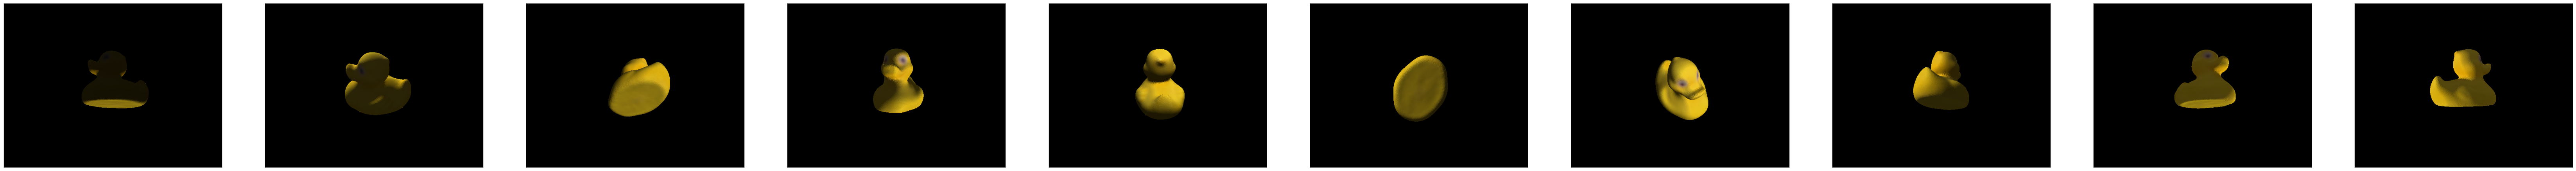

In [29]:
%matplotlib inline
from plot_utils import plot_image_grid

figure = plot_image_grid([rgb_images], transpose=True)

***Note:*** As a reminder, [**`renderer.py`**](./renderer.py) contains the complete code in a more object-oriented and reusable way, with some additional utility function.

## Conclusion

While this was a lot of notions to cover and code to implement, we built a complete rendering pipeline. With some minor tweaking, this code can be used to render large amounts of synthetic images from 3D models. Adding some image augmentations to these images (c.f. Chapter 7), they can be fed to computer vision models for their training. This is what we will try to do in the next notebook, using a pre-rendered dataset of synthetic images to train a CNN for semantic segmentation.

<a id="ref"></a>
#### References

1. Turk, G., 1998. The PLY polygon file format. Georgia Institute of Technology.
2. Hinterstoisser, S., Cagniart, C., Ilic, S., Sturm, P., Navab, N., Fua, P. and Lepetit, V., 2011. Gradient response maps for real-time detection of textureless objects. IEEE transactions on pattern analysis and machine intelligence, 34(5), pp.876-888.